<a href="https://colab.research.google.com/github/krishnarevi/TSAI_END2.0_Session7/blob/main/French_to_English_translation_with_OPUS_100_language_pair_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **French to English translation with OPUS-100 language pair dataset**
Here we will be building a sequence to sequence deep learning model using PyTorch and TorchText to translate from French to English.Sequence to Sequence (seq2seq) model here uses an encoder-decoder architecture. Encoder neural network encodes the input sequence(french sentence) into a single vector, also called as a Context Vector,which is an abstract representation of the input sequence.This vector is then passed into the decoder neural network, which is used to output the corresponding output sequence (english translation), one word at a time.

## **Preparing Data**

Import all the required modules.

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.legacy.data import Field, BucketIterator

import spacy
import numpy as np
import random
import math
import time
import torch, torchtext
from torchtext import legacy
from torchtext.legacy import data
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split



We'll set the random seeds for deterministic results.

In [ ]:
#setting  seed
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Mount drive to access dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path='/content/drive/MyDrive/TSAI_data/opus-100-corpus/v1.0/supervised/en-fr/'
# %cd /content/drive/MyDrive/TSAI_data/opus-100-corpus/v1.0/supervised/en-fr

## Dataset
Dataset we use is from OPUS-100 corpus.It is an English-centric multilingual corpus covering 100 languages. OPUS is a growing collection of translated texts from the web.

The entire corpus can be downloaded from opus-100-corpus-v1.0.tar.gz.
Individual language pairs are also available from http://data.statmt.org/opus-100-corpus/v1.0 or from the OPUS object storage, e.g. https://object.pouta.csc.fi/OPUS-100/v1.0/opus-100-corpus-de-en-v1.0.tar.gz (replace 'de-en' with the language pair you need)

OPUS-100 is English-centric, meaning that all training pairs include English on either the source or target side.The OPUS collection is comprised of multiple corpora, ranging from movie subtitles to GNOME documentation to the Bible.

We will use french-english sentence pairs for our french-english neural translation model.The dataset is split into training, development, and test portions.It has been randomly sampled up to 1M sentence pairs per language pair for training and up to 2000 each for development and test. To ensure that there was no overlap (at the monolingual sentence level) between the training and development/test data, filter was applied by creators during sampling to exclude sentences that had already been sampled.

Due to memory constraints in colab , we will be taking only train file (of 1M sentence pairs) and splitting into train and test sets in 70:30 ratio.


In [ ]:
# !wget -O en-fr.txt.zip https://object.pouta.csc.fi/OPUS-100/v1.0/opus-100-corpus-en-fr-v1.0.zip
# !unzip en-fr.txt.zip
# !rm en-fr.txt.zip
# !rm OpenSubtitles.en-ru.ids

Let's view first view rows of file with English sequences

In [ ]:
!head -10 /content/drive/MyDrive/TSAI_data/opus-100-corpus/v1.0/supervised/en-fr/opus.en-fr-train.en

The time now is 05:08 .
This Regulation shall enter into force on the seventh day following its publication in the Official Journal of the European Union.
Hello, what's that?
And then I will teach you everything i know.
Did you find something?
Article 6
Oh, honey, it's not your fault.
I'm onto him now.
DG XVI's Internet site (electronic address: http://www.cec.lu/en/comm/dg16/dg16home.html) now contains detailed information in English on pilot projects on innovation, the Information society, new sources of employment and cultural cooperation; the application forms for these innovatory measures can be downloaded in all languages of the European Union.
Here it is.


Let's view first view rows of file with French sequences

In [ ]:
!head -10 /content/drive/MyDrive/TSAI_data/opus-100-corpus/v1.0/supervised/en-fr/opus.en-fr-train.fr

The time now is 05:05 .
Le présent règlement entre en vigueur le septième jour suivant celui de sa publication au Journal officiel de l'Union européenne.
Qu'est-ce que c'est que ça ?
Et alors, je t'apprendrai tout ce que je sais.
Par ici !
Article 6
- Tu n'es pas responsable.
Je le tiens.
Par ailleurs, le site Internet de la DG XVI (adresse électronique: http://www.cec.lu/en/comm/dg16/dg16home.html) contient désormais une information détaillée en anglais sur les projets pilotes relatifs à la promotion de l'innovation, à la société de l'information, aux nouveaux gisements d'emploi et à la coopération culturelle; et il permet de décharger les formulaires d'inscription pour ces actions novatrices dans toutes les langues de l'Union européenne.
Le voilà.


Create train and test dataframes processing text files

In [ ]:
def create_dataset(path,fr_data,en_data,total_lines):
  fr_file = open(path+fr_data, 'r')
  en_file = open(path+en_data, 'r')

  dataset = {'en': [],'fr': []}


  for i in tqdm(range(total_lines), total=total_lines):
      fr_text = fr_file.readline()
      en_text = en_file.readline()

      if not en_text and not fr_text:
          # one of file is finished
          break

      fr_text = fr_text.strip()
      en_text = en_text.strip()
      if not en_text or not fr_text:
          continue

      dataset['fr'].append(fr_text)
      dataset['en'].append(en_text)
  fr_file, en_file = None, None

  del fr_file
  del en_file

  df = pd.DataFrame(dataset)
  # print(df.head())
  return df

In [ ]:
df=create_dataset(path,fr_data='opus.en-fr-train.fr',en_data='opus.en-fr-train.en',total_lines=100_000)


100%|██████████| 100000/100000 [00:00<00:00, 472356.53it/s]


Now we will restrict maximum sentence length to 10 due to GPU memory issue

In [ ]:
MAX_LENGTH=10
def process_data(en,fr):

   sentence1, sentence2 = list(en),list(fr)

   pairs = []
   for i in range(len(en)):
       if len(sentence1[i].split(' ')) < MAX_LENGTH and len(sentence2[i].split(' ')) < MAX_LENGTH:
           full = (sentence1[i], sentence2[i])
           pairs.append(full)

   return pairs

   

In [ ]:
processed_data = pd.DataFrame(process_data(df.en,df.fr), columns =['en', 'fr'])

In [ ]:
processed_data.tail()

,en,fr
47208,"Yeah, so?",Et alors ?
47209,Carmen!,Carmen !
47210,- Why are you such an idiot.,- Quel crétin.
47211,As a kid you're taught that queers are funny.,On vous dit que les homos sont bizarres.
47212,sexy redhead (2),sexy redhead (2)


Let's check if any nan rows are there

In [ ]:
print(f'sum of nan rows of train set {df.isnull().sum()}')

sum of nan rows of train set en    0
fr    0
dtype: int64


In [ ]:
(df_train, df_test) = train_test_split(processed_data, test_size=0.3, random_state=random.seed(SEED))
assert len(df_train) + len(df_test) == len(processed_data)
df_train=df_train.reset_index(drop=True)
df_test=df_test.reset_index(drop=True)

In [ ]:
print(f'Length of train  dataset \n{len(df_train)}')
df_train.tail()

Length of train  dataset 
33049


,en,fr
33044,Mr. Walter Davis.,M. Walter Davis.
33045,- Tell him to come in.,- Dis-lui d'entrer.
33046,I felt like I'd done something terrible.,Comme si j'avais fait une chose horrible.
33047,> Stewardship and the convention on biological...,> L'intendance et la Convention sur la diversi...
33048,"Why do people complicate their lives so, Martha?",Pourquoi les gens se compliquent-ils tant la vie?


In [ ]:
print(f'Length of test  dataset \n{len(df_test)}')
df_test.tail()

Length of test  dataset 
14164


,en,fr
14159,"Miss, look. Gem's in trouble.",Gem a des problèmes.
14160,- Word of honour? - No,- Vrai de vrai ?
14161,Listed on the Canadian Register: 2009/09/10,Inscrit au répertoire canadien: 2009/09/10
14162,Not an authorised complainant(62),Plaignant non habilité (62)
14163,"International Assistance Group, Justice Canada","International Assistance Group, Justice Canada"


In [ ]:
# !pip3 install -U spacy --quiet


In [ ]:
%%bash
python -m spacy download en --quiet
python -m spacy download fr --quiet

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/fr_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/fr
You can now load the model via spacy.load('fr')


Load the French and English spaCy models.

In [ ]:
spacy_fr = spacy.load('fr')
spacy_en = spacy.load('en')


We create the tokenizers.

In [ ]:
def tokenize_fr(text):
    """
    Tokenizes french sequence from a string into a list of strings (tokens) and reverses it
    """
    return [tok.text for tok in spacy_fr.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes english sequence from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]
### Sample Run ###

sample_text = "I love machine learning"
print(tokenize_en(sample_text))
print(tokenize_fr(sample_text))

['I', 'love', 'machine', 'learning']
['I', 'love', 'machine', 'learning']


Here our source (SRC - Input) is *french sequence* and target (TRG - Output) is *english sequence*. We also add 2 extra tokens "start of sequence" and "end of sequence" for effective model training.

In [ ]:
SRC = Field(tokenize = tokenize_fr, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)


In [ ]:
fields=[('fr',SRC),('en',TRG)]

In [ ]:
example_train=[data.Example.fromlist([df_train.fr[i],df_train.en[i]],fields) for i in range (df_train.shape[0])]
example_test=[data.Example.fromlist([df_test.fr[i],df_test.en[i]],fields) for i in range (df_test.shape[0])]


Create dataset

In [ ]:
train_data = data.Dataset(example_train, fields)
test_data= data.Dataset(example_test,fields)



Let's look at one of the examples in the training set

In [ ]:
print(vars(train_data.examples[0]))

{'fr': ['ce', 'sont', 'des', 'pas', '.'], 'en': ['it', "'s", 'footsteps', '.']}


Build vocabulary

In [ ]:
MAX_VOCAB_SIZE=25_000
SRC.build_vocab(train_data,min_freq=2,max_size=MAX_VOCAB_SIZE)
TRG.build_vocab(train_data,min_freq=2,max_size=MAX_VOCAB_SIZE)

In [ ]:
print(f"Unique tokens in source (fr) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (fr) vocabulary: 7652
Unique tokens in target (en) vocabulary: 6915


Define the device

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Create the iterators

In [ ]:
BATCH_SIZE=32
train_iterator, test_iterator = BucketIterator.splits(
    (train_data,  test_data), 
    batch_size = BATCH_SIZE,sort_within_batch = True,
    sort_key = lambda x: len(x.fr),
    device = device)

## **Building seq2seq Model**
We'll be building our model in three parts. The encoder, the decoder and a seq2seq model that encapsulates the encoder and decoder and will provide a way to interface with each.

 #### Encoder Model 
 First, the encoder, a 2 layer LSTM.

For a multi-layer LSTM, the input sentence, $X$, after being embedded goes into the first (bottom) layer of the LSTM.Along with input sequence , LSTM take in hidden state and cell state from previous time step and return new hidden state and cell state at each time step.Initial hidden state and cell state will be initialized to tensor of all zeros.Only hidden state from the first layer is passed as input to the second layer, and not the cell state.We will also output a context vector per layer, $z^l$.Our context vector will be both the final hidden state and the final cell state, i.e. $z^l = (h_T^l, c_T^l)$.

Thus, representing each layer with a superscript, the hidden states in each layer are given by:

$$\begin{align*}
(h_t^1, c_t^1) = \text{EncoderLSTM}^1(e(x_t), (h_{t-1}^1, c_{t-1}^1))\\
(h_t^2, c_t^2) = \text{EncoderLSTM}^2(h_t^1, (h_{t-1}^2, c_{t-1}^2))
\end{align*}$$



We create this in code by making an Encoder module, which  inherit from `torch.nn.Module` and use the `super().__init__()` as some boilerplate code. The encoder takes the following arguments:


*   `input_dim` is the size/dimensionality of the one-hot vectors that will be input to the encoder. This is equal to the input (source) vocabulary size.
*   `emb_dim` is the dimensionality of the embedding layer. This layer converts the one-hot vectors into dense vectors with emb_dim dimensions.
*  `hid_dim` is the dimensionality of the hidden and cell states.
*   `n_layers` is the number of layers in the LSTM.

*   `dropout` is the amount of dropout to use. This is a regularization parameter to prevent overfitting.


In the `forward` method, we pass in the source sentence, $X$, which is converted into dense vectors using the embedding layer, and then dropout is applied. These embeddings are then passed into the LSTM. As we pass a whole sequence to the LSTM, it will automatically do the recurrent calculation of the hidden states over the whole sequence.We do not pass an initial hidden or cell state to the LSTM. This is because, if no hidden/cell state is passed to the LSTM, it will automatically create an initial hidden/cell state as a tensor of all zeros.

The LSTM returns: outputs (the top-layer hidden state for each time-step), hidden (the final hidden state for each layer, $h_T$, stacked on top of each other) and cell (the final cell state for each layer, $c_T$, stacked on top of each other).

As we only need the final hidden and cell states (to make our context vector), forward only returns hidden and cell.



In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, (hidden, cell) = self.rnn(embedded)
        
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell





    

#### Decoder  
Next, we'll build our decoder, which will also be a 2-layer  LSTM.

The Decoder class does a single step of decoding, i.e. it ouputs single token per time-step. The first layer will receive a hidden and cell state from the previous time-step, $(s_{t-1}^1, c_{t-1}^1)$, and feeds it through the LSTM with the current embedded token, $y_t$, to produce a new hidden and cell state, $(s_t^1, c_t^1)$. The subsequent layers will use the hidden state from the layer below, $s_t^{l-1}$, and the previous hidden and cell states from their layer, $(s_{t-1}^l, c_{t-1}^l)$. This provides equations very similar to those in the encoder.

$$\begin{align*}
(s_t^1, c_t^1) = \text{DecoderLSTM}^1(d(y_t), (s_{t-1}^1, c_{t-1}^1))\\
(s_t^2, c_t^2) = \text{DecoderLSTM}^2(s_t^1, (s_{t-1}^2, c_{t-1}^2))
\end{align*}$$
Remember that the initial hidden and cell states to our decoder are our context vectors, which are the final hidden and cell states of our encoder from the same layer, i.e. $(s_0^l,c_0^l)=z^l=(h_T^l,c_T^l)$.

We then pass the hidden state from the top layer of the RNN, $s_t^L$, through a linear layer, $f$, to make a prediction of what the next token in the target (output) sequence should be, $\hat{y}_{t+1}$.

$$\hat{y}_{t+1} = f(s_t^L)$$
The arguments and initialization are similar to the Encoder class, except we now have an output_dim which is the size of the vocabulary for the output/target. There is also the addition of the Linear layer, used to make the predictions from the top layer hidden state.

Within the forward method, we accept a batch of input tokens, previous hidden states and previous cell states. As we are only decoding one token at a time, the input tokens will always have a sequence length of 1. We unsqueeze the input tokens to add a sentence length dimension of 1. Then, similar to the encoder, we pass through an embedding layer and apply dropout. This batch of embedded tokens is then passed into the RNN with the previous hidden and cell states. This produces an output (hidden state from the top layer of the RNN), a new hidden state (one for each layer, stacked on top of each other) and a new cell state (also one per layer, stacked on top of each other). We then pass the output (after getting rid of the sentence length dimension) through the linear layer to receive our prediction. We then return the prediction, the new hidden state and the new cell state.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
                
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        prediction = self.fc_out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell



#### Seq2Seq (Encoder + Decoder) 
For the final part of the implemenetation, we'll implement the `seq2seq` model. This will handle:

*   receiving the input/source sentence
*   using the encoder to produce the context vectors
*   using the decoder to produce the predicted output/target sentence


The `Seq2Seq` model takes in an `Encoder`, `Decoder`, and a `device` (used to place tensors on the GPU, if it exists).

Our `forward` method takes the source sentence, target sentence and a `teacher-forcing ratio`. The `teacher forcing ratio` is used when training our model. When decoding, at each time-step we will predict what the next token in the target sequence will be from the previous tokens decoded, $\hat{y}_{t+1}=f(s_t^L)$. With probability equal to the teaching forcing ratio (`teacher_forcing_ratio`) we will use the actual ground-truth next token in the sequence as the input to the decoder during the next time-step. However, with probability 1 - `teacher_forcing_ratio`, we will use the token that the model predicted as the next input to the model, even if it doesn't match the actual next token in the sequence.

The first thing we do in the forward method is to create an outputs tensor that will store all of our predictions, $\hat{Y}$.

We then feed the input/source sentence, `src`, into the encoder and receive out final hidden and cell states.

The first input to the decoder is the start of sequence (`<sos>`) token. As our trg tensor already has the `<sos>` token appended we get our $y_1$ by slicing into it. We know how long our target sentences should be (max_len), so we loop that many times. The last token input into the decoder is the one before the `<eos>` token - the <eos> token is never input into the decoder.

During each iteration of the loop, we:



*   pass the input, previous hidden and previous cell states ($y_t, s_{t-1}, c_{t-1}$) into the decoder
*   receive a prediction, next hidden state and next cell state ($\hat{y}_{t+1}, s_{t}, c_{t}$) from the decoder
*   place our prediction, $\hat{y}_{t+1}$/output in our tensor of predictions, $\hat{Y}$/outputs
*  decide if we are going to "teacher force" or not
  *  if we do, the next input is the ground-truth next token in the sequence, $y_{t+1}$/trg[t]
  *   if we don't, the next input is the predicted next token in the sequence, $\hat{y}_{t+1}$/top1, which we get by doing an argmax over the output tensor

Once we've made all of our predictions, we return our tensor full of predictions, $\hat{Y}$/outputs.







In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
        
        return outputs



##  **Training Model**

We  define the encoder, decoder and then our Seq2Seq model, which we place on the device.

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.2
DEC_DROPOUT = 0.2

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)

Next up is initializing the weights of our model.We initialize all weights from a uniform distribution between -0.08 and +0.08.We initialize weights in PyTorch by creating a function which we apply to our model. When using apply, the init_weights function will be called on every module and sub-module within our model. For each module we loop through all of the parameters and sample them from a uniform distribution with `nn.init.uniform_`.

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7652, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.2)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6915, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.2)
    (fc_out): Linear(in_features=512, out_features=6915, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
)

We also define a function that will calculate the number of trainable parameters in the model.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,632,963 trainable parameters



We define our optimizer, which we use to update our parameters in the training loop. Here, we'll use Adam.

In [ ]:
optimizer = optim.Adam(model.parameters(),lr=1e-4)

Next, we define our loss function as `CrossEntropyLoss` function 

Our loss function calculates the average loss per token, however by passing the index of the <pad> token as the `ignore_index` argument we ignore the loss whenever the target token is a padding token.

In [ ]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)
TRG_PAD_IDX

1

Next, we'll define our training loop.

First, we'll set the model into "training mode" with model and then iterate through our data iterator.



In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        #get the source and target sentences from the batch
        fr = batch.fr
        en = batch.en
        
        optimizer.zero_grad()#zero the gradients calculated from the last batch
        
        output = model(fr, en)#feed the source and target into the model to get the output
        
        #en = [sentence len, batch size]
        #output = [sentence len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        
        output = output[1:].view(-1, output_dim)#as the loss function only works on 2d inputs with 1d targets flatten each of them
        en = en[1:].view(-1)
        
        #en = [(en - 1) * batch size]
        #output = [(en len - 1) * batch size, output dim]
        
        loss = criterion(output, en)
        
        loss.backward()#calculate the gradients
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)#clip the gradients to prevent them from exploding 
        
        optimizer.step()# update the parameters 
        
        epoch_loss += loss.item()#sum the loss value to a running total
        
    return epoch_loss / len(iterator)

Next, we'll define our evaluation loop.


In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            fr = batch.fr
            en = batch.en

            output = model(fr, en, 0) #turn off teacher forcing


            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            en = en[1:].view(-1)



            loss = criterion(output, en)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)


Next, we'll create a function that we'll use to tell us how long an epoch takes.

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

We can finally start training our model!

At each epoch, we'll be checking if our model has achieved the best validation loss so far. If it has, we'll update our best validation loss and save the parameters of our model . Then, when we come to test our model, we'll use the saved parameters used to achieve the best validation loss.

We'll be printing out both the loss and the perplexity at each epoch. It is easier to see a change in perplexity than a change in loss as the numbers are much bigger.

In [ ]:
N_EPOCHS = 30
CLIP = 1
train_los=[]
test_los=[]
best_test_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    train_los.append(train_loss)
    test_loss = evaluate(model, test_iterator, criterion)
    test_los.append(test_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), 'saved-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Test. Loss: {test_loss:.3f} |  Test. PPL: {math.exp(test_loss):7.3f}')

Epoch: 01 | Time: 0m 40s
	Train Loss: 5.172 | Train PPL: 176.306
	 Test. Loss: 4.715 |  Test. PPL: 111.560
Epoch: 02 | Time: 0m 40s
	Train Loss: 4.607 | Train PPL: 100.219
	 Test. Loss: 4.468 |  Test. PPL:  87.151
Epoch: 03 | Time: 0m 40s
	Train Loss: 4.382 | Train PPL:  80.000
	 Test. Loss: 4.342 |  Test. PPL:  76.825
Epoch: 04 | Time: 0m 40s
	Train Loss: 4.237 | Train PPL:  69.221
	 Test. Loss: 4.295 |  Test. PPL:  73.332
Epoch: 05 | Time: 0m 40s
	Train Loss: 4.134 | Train PPL:  62.418
	 Test. Loss: 4.235 |  Test. PPL:  69.070
Epoch: 06 | Time: 0m 40s
	Train Loss: 4.040 | Train PPL:  56.831
	 Test. Loss: 4.196 |  Test. PPL:  66.418
Epoch: 07 | Time: 0m 40s
	Train Loss: 3.951 | Train PPL:  51.966
	 Test. Loss: 4.160 |  Test. PPL:  64.071
Epoch: 08 | Time: 0m 40s
	Train Loss: 3.869 | Train PPL:  47.909
	 Test. Loss: 4.136 |  Test. PPL:  62.577
Epoch: 09 | Time: 0m 40s
	Train Loss: 3.800 | Train PPL:  44.691
	 Test. Loss: 4.120 |  Test. PPL:  61.581
Epoch: 10 | Time: 0m 40s
	Train Loss:

Let's view train and test loss of our model

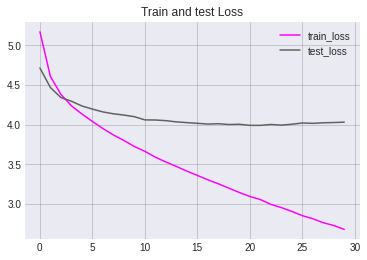

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
plt.figure()
plt.plot(train_los, color = 'magenta')
plt.plot(test_los, color = '#606060')
plt.title('Train and test Loss')
plt.legend(['train_loss', 'test_loss'], loc = 'upper right')
plt.grid(axis = 'y', c = 'black', alpha = 0.2)
plt.grid(axis = 'x', c = 'black', alpha = 0.2)

## **Inference**


Now, we'll grab some answers to questions from our dataset and see how well our model did.

In [ ]:
def predict_duplicate(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('fr_core_news_sm')
        #('en_core_web_sm')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    # src_len = torch.LongTensor([len(src_indexes)])
    
    with torch.no_grad():
        hidden,cell = model.encoder(src_tensor)

        
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    # attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    
    for i in range(max_len):

        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
                
        with torch.no_grad():
            output, hidden, cell = model.decoder(trg_tensor, hidden, cell)
            # output, hidden, cell = model.decoder(trg_tensor, hidden, cell)

            
        pred_token = output.argmax(1).item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:]

In [ ]:
example_idx = 39

src = vars(train_data.examples[example_idx])['fr']
trg = vars(train_data.examples[example_idx])['en']

print(f'src = {src}')
print(f'trg = {trg}')
translate_sentence= predict_duplicate(src, SRC, TRG, model, device)

print(f'predicted trg = {translate_sentence}')

src = ['entre', '.']
trg = ['come', 'in', '.']
predicted trg = ['come', 'in', '.', '<eos>']


Let's predict some answers from test set too

In [ ]:
example_idx = 15

src = vars(test_data.examples[example_idx])['fr']
trg = vars(test_data.examples[example_idx])['en']

print(f'src = {src}')
print(f'trg = {trg}')
translate_sentence= predict_duplicate(src, SRC, TRG, model, device)

print(f'predicted trg = {translate_sentence}')

src = ['qui', 'êtes', '-', 'vous', '?']
trg = ['what', 'are', 'you', 'doing', 'here', '?']
predicted trg = ['who', 'are', 'you', '?', '<eos>']


In [ ]:
example_idx =85

src = vars(test_data.examples[example_idx])['fr']
trg = vars(test_data.examples[example_idx])['en']

print(f'src = {src}')
print(f'trg = {trg}')
translate_sentence= predict_duplicate(src, SRC, TRG, model, device)

print(f'predicted trg = {translate_sentence}')

src = ['sommaire']
trg = ['contents']
predicted trg = ['contents', '<eos>']


In [ ]:
example_idx =86

src = vars(test_data.examples[example_idx])['fr']
trg = vars(test_data.examples[example_idx])['en']

print(f'src = {src}')
print(f'trg = {trg}')
translate_sentence= predict_duplicate(src, SRC, TRG, model, device)

print(f'predicted trg = {translate_sentence}')

src = ['tu', 'reviens', 'quand', 'à', "l'", 'école', '?']
trg = ['when', 'are', 'you', 'coming', 'back', 'to', 'the', 'kindergarten', '?']
predicted trg = ['you', 'you', 'gon', 'na', 'be', 'back', '?', '<eos>']
